In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

/gpfs3/well/clifton/users/wra194/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load features & outcomes

In [2]:
# Load features & outcomes
features = pd.read_feather('../data/processed/features_processed.feather')
outcomes = pd.read_feather('../data/processed/surv_outcomes_crc.feather')

# Only select features for individuals included in outcomes (i.e. following exclusion criteria)
features = features[features['eid'].isin(outcomes['eid'])]

In [3]:
# Cox negative log likelihood loss function can only be fed one y column, so have to encode censored individuals as negative T.
# See https://github.com/xiaonanl1996/MLforBrCa/blob/main/Scripts/Stats_Analysis/JupyterNotebook/XGBoost-Cox.ipynb (Thanks!)
outcomes.loc[outcomes['E'] == 0, 'T'] = -outcomes['T']

In [4]:
# Train test split, ensuring row:row match between features & outcomes (by ordering both by ID)
X_train, X_test, y_train, y_test = train_test_split(features.sort_values(by='eid'), outcomes.sort_values(by='eid'), test_size=.2, random_state=42)

In [5]:
dtrain = xgb.DMatrix(X_train.drop(columns='eid'), label=y_train['T'], enable_categorical=True)
dtest = xgb.DMatrix(X_test.drop(columns='eid'), label=y_test['T'], enable_categorical=True)

In [6]:
print("Training features shape: ", X_train.drop(columns='eid').shape)
print(f"DMatrix shape: ({dtrain.num_row()}, {dtrain.num_col()})")

Training features shape:  (352178, 1546)
DMatrix shape: (352178, 1546)


Run basic XGBoost. For now, just use basic model with final hyperparameters from <a href='https://doi.org/10.1038/s41598-023-36214-0'>Liu 2023</a>. Hyperparameter tuning to come.

In [8]:
params = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'eta': 0.01,
    'max_depth': 2,
    'min_child_weight': 3, 
    'gamma': 1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    'lambda': 20,
    'random_state': 42,
    'device': 'cuda',
    'tree_method': 'hist',
}

model = xgb.train(params, dtrain, 
    num_boost_round=50000,
    evals=[(dtest, "test")],
    early_stopping_rounds=200,
    verbose_eval=100)

[0]	test-cox-nloglik:10.90707
[100]	test-cox-nloglik:10.74676
[200]	test-cox-nloglik:10.68379
[300]	test-cox-nloglik:10.65008
[400]	test-cox-nloglik:10.62859
[500]	test-cox-nloglik:10.61308
[600]	test-cox-nloglik:10.60220
[700]	test-cox-nloglik:10.59391
[800]	test-cox-nloglik:10.58845
[900]	test-cox-nloglik:10.58422
[1000]	test-cox-nloglik:10.58134
[1100]	test-cox-nloglik:10.57907
[1200]	test-cox-nloglik:10.57630
[1300]	test-cox-nloglik:10.57459
[1400]	test-cox-nloglik:10.57221
[1500]	test-cox-nloglik:10.56981
[1600]	test-cox-nloglik:10.56818
[1700]	test-cox-nloglik:10.56706
[1800]	test-cox-nloglik:10.56554
[1900]	test-cox-nloglik:10.56438
[2000]	test-cox-nloglik:10.56413
[2100]	test-cox-nloglik:10.56320
[2200]	test-cox-nloglik:10.56234
[2300]	test-cox-nloglik:10.56142
[2400]	test-cox-nloglik:10.56095
[2500]	test-cox-nloglik:10.56035
[2600]	test-cox-nloglik:10.55952
[2700]	test-cox-nloglik:10.55871
[2800]	test-cox-nloglik:10.55792
[2900]	test-cox-nloglik:10.55737
[3000]	test-cox-nlogli

In [9]:
# Set pretty names for features. Format: Feature title (UKB feature ID)
fields_metadata = pd.read_csv('../data/raw/ukb_metadata/field.txt', sep='\t')
pretty_names = []
for col in features.columns[1:]:
    field_id = int(col.split('.')[0])
    field_title = fields_metadata.loc[fields_metadata['field_id'] == field_id, 'title'].tolist()[0]
    # If one-hot-encoded multi-choice, set field title + choice
    if '_' in col:
        pretty_names.append(field_title + f" ({field_id}): {col.split('_')[1]}")
    # Otherwise just set to field title
    else:
        pretty_names.append(field_title + f" ({field_id})")

In [10]:
# Compute SHAP values. For some reason, throws additivity error/warning when using GPU, so set check_additivity=False for now.
explainer = shap.Explainer(model, feature_names=pretty_names)
shap_values = explainer(dtrain, check_additivity=False)

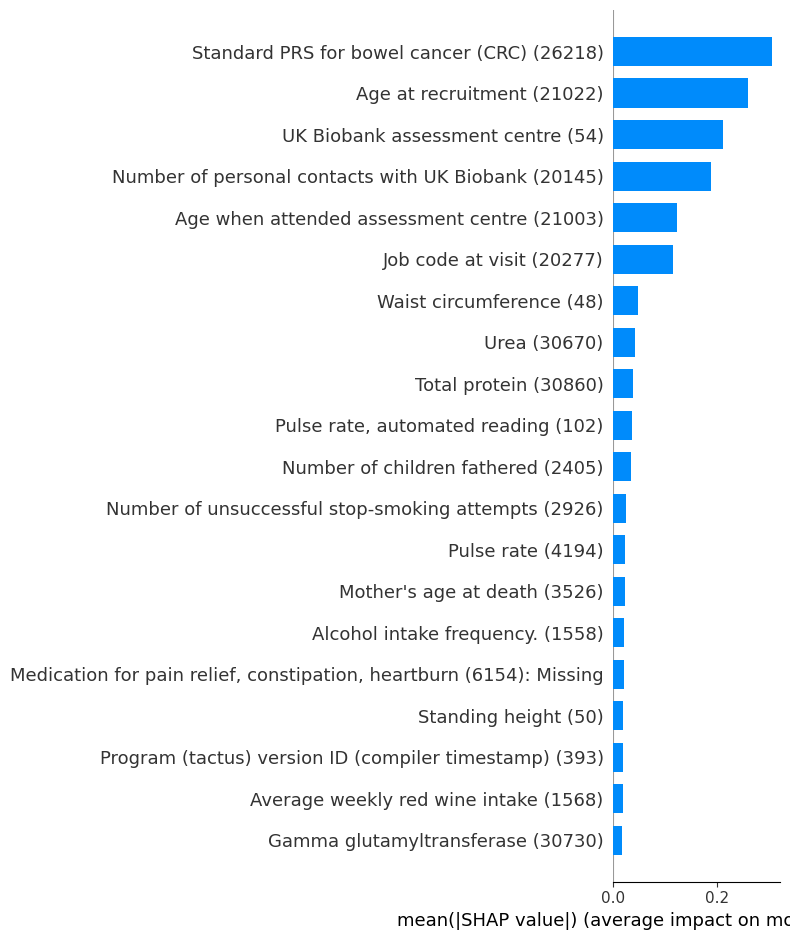

In [11]:
# SHAP summary plot
shap.summary_plot(shap_values, plot_type="bar", max_display=20)

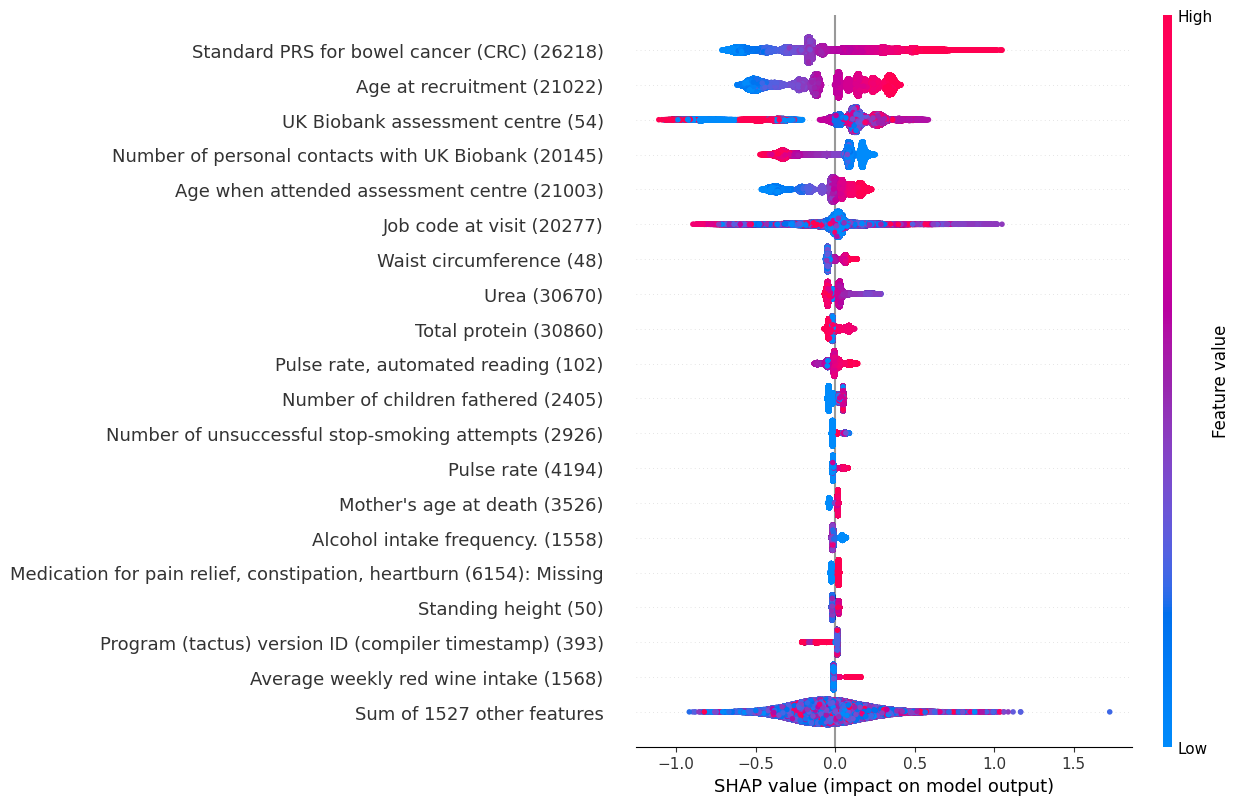

In [12]:
# Beeswarm plot
shap.plots.beeswarm(shap_values, max_display=20)